In [1]:
#import transformers
import os
from dotenv import load_dotenv
load_dotenv()
import re
import string
import json
import time
import openai
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
import seaborn as sns

#import torch
#from huggingface_hub import notebook_login
#from transformers import pipeline
#from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel

import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
stoplist=stopwords.words('english')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer= WordNetLemmatizer()
from nltk.corpus import wordnet

#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary
from gensim.models import Phrases
from collections import Counter
from gensim.models import Word2Vec
from gensim.models.ldamulticore import LdaMulticore

## Importing gensim related libraries

In [46]:
#path = '../../datasets/test_dataset_model_pipeline/collected_statements_v0.5.csv'
path = '../../datasets/test_dataset_model_pipeline/future_statements.csv'

df_orig = pd.read_csv(path, sep='|', error_bad_lines=False)
df_orig.columns

/tmp/ipykernel_1505387/3005824122.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_orig = pd.read_csv(path, sep='|', error_bad_lines=False)


Index(['statement', 'sentiment', 'topic', 'url'], dtype='object')

In [49]:
"""
This function is used to get the part-of-speech(POS) for lemmatization
"""
def get_tags(tag):
   if tag.startswith('N') or tag.startswith('J'):
      return wordnet.NOUN
   #elif tag.startswith('J'):
   #   return wordnet.ADJ
   elif tag.startswith('V'):
      return wordnet.VERB
   elif tag.startswith('R'):
      return wordnet.ADV
   else:
      return wordnet.NOUN #default case

"""
1. Removes Punctuations
2. Removes words smaller than 3 letters
3. Converts into lowercase
4. Lemmatizes words
5. Removes Stopwords
"""
def preprocess(text):
   punctuation = list(string.punctuation)
   doc_tokens = nltk.word_tokenize(text)
   #print('doc_tokens', doc_tokens)
   word_tokens = [word.lower() for word in doc_tokens if not (word in punctuation or len(word)<=3)]
   # Lemmatize
   _pos_tags = nltk.pos_tag(word_tokens)
   pos_tags = []
   for i in _pos_tags:
      if re.search(r'(N)\w+',i[1]):
         pos_tags.append(i)
   #print('pos_tags:',pos_tags)
   doc_words = [wordnet_lemmatizer.lemmatize(word, pos = get_tags(tag)) for word, tag in pos_tags]
   doc_words = [word for word in doc_words if word not in stoplist]
   #print('doc_words', doc_words)
   return doc_words

In [50]:
df_clean = df_orig['statement'].apply(preprocess)

In [51]:
# df_orig_s = df_orig.loc[5:8,:]
# df_orig_s['cut'] = df_orig_s['statement'].apply(preprocess)
# df_orig_s

In [52]:
docs= list(df_clean)
phrases = gensim.models.Phrases(docs, min_count=10, threshold=20)
bigram_model = gensim.models.phrases.Phraser(phrases)

In [53]:
'''
create bigrams from statements
'''
def make_bigrams(texts):
    return [bigram_model[doc] for doc in texts]

In [54]:
# Form Bigrams
data_words_bigrams = make_bigrams(docs)

In [55]:
# Checkout most frequent bigrams
bigram_counter1 = Counter()
for key in phrases.vocab.keys():
    if key not in stopwords.words('english'):
        if len(str(key).split('_'))>1:
            bigram_counter1[key]+=phrases.vocab[key]

for key, counts in bigram_counter1.most_common(50):
    print(key,"->", counts)

data_mining -> 833
test_data -> 704
voice_recognition -> 470
speech_recognition -> 426
machine_translation -> 202
face_recognition -> 195
recognition_software -> 173
computer_vision -> 140
recognition_technology -> 126
pattern_recognition -> 103
language_processing -> 103
machine_intelligence -> 90
recognition_system -> 84
training_data -> 72
autopilot_system -> 69
forex_autopilot -> 67
computer_science -> 66
data_data -> 62
machine_learning -> 58
supercomputer_center -> 50
data_test -> 50
money_autopilot -> 49
search_engine -> 48
mining_tool -> 47
data_analysis -> 44
business_intelligence -> 42
game_player -> 40
system_system -> 40
sentiment_analysis -> 38
intelligence_system -> 38
business_autopilot -> 35
player_game -> 35
intelligence_intelligence -> 35
information_technology -> 32
technology_intelligence -> 31
recognition_application -> 31
mining_technique -> 30
mining_data -> 29
autopilot_cash -> 29
system_data -> 28
information_system -> 28
game_game -> 27
data_set -> 26
player_p

In [56]:
# modelstep: Feeding the bigrams into a Word2Vec model produces more meaningful bigrams
w2vmodel = Word2Vec(sentences=bigram_model[docs], vector_size=100, sg=1, hs= 1, seed=33)
bigram_counter = Counter()

for key in w2vmodel.wv.key_to_index.keys(): #deprecated: w2vmodel.wv.vocab.keys()
    if key not in stoplist:
        if len(str(key).split("_")) > 1:
            bigram_counter[key] += w2vmodel.wv.get_vecattr(key, "count")

In [57]:
# get n most common bigrams
for key, counts in bigram_counter.most_common(50):
    print(key,"-> -> " ,counts)

data_mining -> ->  833
voice_recognition -> ->  470
speech_recognition -> ->  426
machine_translation -> ->  202
face_recognition -> ->  195
computer_vision -> ->  140
language_processing -> ->  103
pattern_recognition -> ->  103
forex_autopilot -> ->  66
machine_learning -> ->  58
supercomputer_center -> ->  50
search_engine -> ->  48
sentiment_analysis -> ->  38
difficulty_level -> ->  23
cash_formula -> ->  21
post_location -> ->  20
decision_support -> ->  19
checkpoint_ccse -> ->  18
join_date -> ->  18
information_retrieval -> ->  18
knowledge_discovery -> ->  17
image_processing -> ->  17
credit_card -> ->  16
review_forex -> ->  14
health_care -> ->  14
bbeyonce_girl -> ->  14
command_station -> ->  13
currency_trading -> ->  12
megadroid_review -> ->  12
olap_cube -> ->  11
university_california -> ->  11
flight_simulator -> ->  11
reality_wrestling -> ->  11


In [58]:
# adjacent words, Example for network graph
# w2vmodel.wv.most_similar(positive=['climate_change'], topn=2)

In [65]:
# Create a dictionary and corpus for input to our LDA model
# Filter out the most common and uncommon words
dictionary = Dictionary(data_words_bigrams)
print('Number of unique tokens (before filter): %d' % len(dictionary))

# Filter out words that occur less than x documents, or more than y% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.6)
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens (after filter): %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens (before filter): 11215
Number of unique tokens (after filter): 802
Number of documents: 15541


In [66]:
# params for lda multicore
num_topics = 5
passes = 150 # Number of passes through the corpus during training.
np.random.seed(1)

In [67]:
# train LDA model/topic model
t0 = time.time()
ldamodel = LdaMulticore(corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        alpha='asymmetric',
                        chunksize= 4000,
                        batch= True,
                        minimum_probability=0.001,
                        iterations=350,
                        passes=passes
                        )

t1= time.time()
print("time for",passes," passes: ",(t1-t0)," seconds")

time for 150  passes:  560.2534658908844  seconds


In [95]:
d_topics = {}
d_topics_clean = {}

for i in range(0, num_topics):
    d_topics[i] = ldamodel.show_topics(num_words=10, formatted=False)[i][1]
#for i in d:
#[item[0] for item in second_topic]
for key in d_topics:
    list(d_topics.values())[key]
    d_topics_clean[key] = [item[0] for item in list(d_topics.values())[key]]

In [96]:
# for key in d_topics_clean:
    # print(list(d_topics_clean.values())[key])

In [97]:
# Store major topic
#lda_corpus = ldamodel[corpus]

In [98]:
# main topic for all reviews
all_topics = ldamodel.get_document_topics(corpus)
num_docs = len(all_topics)

all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()

major_topic = [np.argmax(arr) for arr in all_topics_numpy]
df_orig['major_lda_topic'] = major_topic

<AxesSubplot:>

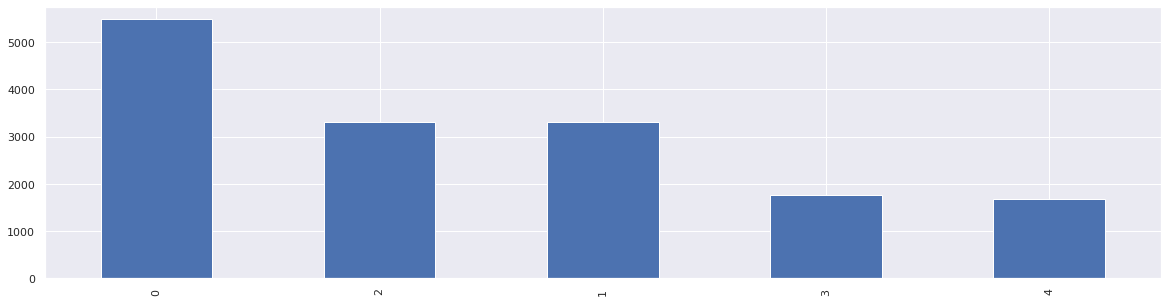

In [99]:
# distribution of topics in statements

sns.set(rc= {'figure.figsize': (20,5)})
sns.set_style('darkgrid')

df_orig.major_lda_topic.value_counts().plot(kind='bar')

In [100]:
keywords_openai = {}
for key in d_topics_clean:
    #keywords_string = ', '.join(sorted(list(d_topics_clean.values())[key]))
    keywords_string = ''
    for index, item in enumerate(sorted(list(d_topics_clean.values())[key])):
        if index < len(list(d_topics_clean.values())[key])-1:
            keywords_string = keywords_string + item + ', '
        else:
            keywords_string = keywords_string + item
    print(keywords_string + '\n')
    keywords_openai[key] = keywords_string

computer, face, people, recognition, software, speech, system, technology, time, voice

change, enemy, file, game, level, network, player, point, team, time

analysis, analytics, data, information, mining, research, supercomputer, system, test, tool

autopilot, business, flight, forex, money, review, system, time, trading, unit

computer, human, intelligence, language, machine, processing, science, technology, translation, world



In [101]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [102]:
for key_one in range(0, (len(d_topics_clean)-1)):
    for key_two in range(key_one+1, len(d_topics_clean)):
        inter = intersection(sorted(d_topics_clean[key_one]), sorted(d_topics_clean[key_two]))
        print('Intersect of topic %d [%d] and topic %d [%d]: %d'%(key_one, len(d_topics_clean[key_one]), (key_two), len(d_topics_clean[key_two]), len(inter)))
        print('-> %s'%inter)

Intersect of topic 0 [10] and topic 1 [10]: 1
-> ['time']
Intersect of topic 0 [10] and topic 2 [10]: 1
-> ['system']
Intersect of topic 0 [10] and topic 3 [10]: 2
-> ['system', 'time']
Intersect of topic 0 [10] and topic 4 [10]: 2
-> ['computer', 'technology']
Intersect of topic 1 [10] and topic 2 [10]: 0
-> []
Intersect of topic 1 [10] and topic 3 [10]: 1
-> ['time']
Intersect of topic 1 [10] and topic 4 [10]: 0
-> []
Intersect of topic 2 [10] and topic 3 [10]: 1
-> ['system']
Intersect of topic 2 [10] and topic 4 [10]: 0
-> []
Intersect of topic 3 [10] and topic 4 [10]: 0
-> []


In [112]:
openai.api_key = os.getenv("OPENAI_API_KEY")

d_topics_subtopics = {}

for key in keywords_openai:
    response = openai.Completion.create(
        model = "text-davinci-002",
        prompt = "One Topic of a maximum of two words for the following keywords: %s"%list(keywords_openai.values())[key],
        temperature = 0.7,
        max_tokens = 256,
        top_p = 1,
        frequency_penalty = 0,
        presence_penalty = 0,
        stop=["\"\"\""]
    )
    response_loaded = response['choices'][0]['text']
    response_list = []

    #remove_pattern_1 = r'\\n[1234567890].'
    #remove_pattern_1 = r'[\w][\d].'
    remove_pattern_1 = r'[\d].'
    remove_pattern_2 = r'\n'

    response_loaded = re.sub(remove_pattern_1, ',', response_loaded)
    response_loaded = re.sub(remove_pattern_2, '', response_loaded)
    response_loaded = response_loaded.split(', ')
    response_loaded = list(filter(None, response_loaded))

    for i in response_loaded:
        print(i)
    print('(%s)'%list(keywords_openai.values())[key])
    print('----')
    d_topics_subtopics[response_loaded[0]] = list(d_topics_clean.values())[key]

Face recognition
(computer, face, people, recognition, software, speech, system, technology, time, voice)
----
New level
(change, enemy, file, game, level, network, player, point, team, time)
----
analytics software
(analysis, analytics, data, information, mining, research, supercomputer, system, test, tool)
----
Forex trading
(autopilot, business, flight, forex, money, review, system, time, trading, unit)
----
The future of computing.
(computer, human, intelligence, language, machine, processing, science, technology, translation, world)
----


In [113]:
# So many verbs and adjectives -> remove before LdaMulticore modeling?
# -> only nouns can be applied in section: '# Filter out words ...'

In [114]:
# a_string = 'a,b,c'
# letter_list = a_string.split(',')

In [115]:
df_test = df_orig.head(2)

In [137]:
def major_lda_topic_to_topic(row, d_topics_subtopics):
    for i in range(0, len(d_topics_subtopics)):
        if row['major_lda_topic'] == i:
            return list(d_topics_subtopics.keys())[i]
    # if row['major_lda_topic'] == 0:
    #     return list(d_topics_subtopics.keys())[0]
    # elif row['major_lda_topic'] == 1:
    #     return list(d_topics_subtopics.keys())[1]
    # elif row['major_lda_topic'] == 2:
    #     return list(d_topics_subtopics.keys())[2]
    # elif row['major_lda_topic'] == 3:
    #     return list(d_topics_subtopics.keys())[3]
    # elif row['major_lda_topic'] == 4:
    #     return list(d_topics_subtopics.keys())[4]

def topic_to_subtopic(row, d_topics_subtopics):
    for ii in range(0, len(d_topics_subtopics)):
        if row['major_lda_topic'] == ii:
            for i in list(d_topics_subtopics.values())[ii]:
                #if row['statement'].str.contains(i, case=False, na=False):
                if re.search(i, row['statement'], re.IGNORECASE):
                    return i
            return 'undefined'
    # if row['major_lda_topic'] == 0:
    #     for i in list(d_topics_subtopics.values())[0]:
    #         #if row['statement'].str.contains(i, case=False, na=False):
    #         if re.search(i, row['statement'], re.IGNORECASE):
    #             return i
    #     return 'undefined'
    # elif row['major_lda_topic'] == 1:
    #     for i in list(d_topics_subtopics.values())[1]:
    #         #if row['statement'].str.contains(i, case=False, na=False):
    #         if re.search(i, row['statement'], re.IGNORECASE):
    #             return i
    #     return 'undefined'
    # elif row['major_lda_topic'] == 2:
    #     for i in list(d_topics_subtopics.values())[2]:
    #         #if row['statement'].str.contains(i, case=False, na=False):
    #         if re.search(i, row['statement'], re.IGNORECASE):
    #             return i
    #     return 'undefined'
    # elif row['major_lda_topic'] == 3:
    #     for i in list(d_topics_subtopics.values())[3]:
    #         #if row['statement'].str.contains(i, case=False, na=False):
    #         if re.search(i, row['statement'], re.IGNORECASE):
    #             return i
    #     return 'undefined'
    # elif row['major_lda_topic'] == 4:
    #     for i in list(d_topics_subtopics.values())[4]:
    #         #if row['statement'].str.contains(i, case=False, na=False):
    #         if re.search(i, row['statement'], re.IGNORECASE):
    #             return i
    #     return 'undefined'

def subtopic_to_network(row, d_topics_subtopics_merged):
    network = []
    for index, item in enumerate(d_topics_subtopics_merged):
        if (re.search(item, row['statement'], re.IGNORECASE)) and (item.casefold() not in network):
            network.append(item)
    return network

In [117]:
df_orig['topic'] = df_orig.apply(lambda row: major_lda_topic_to_topic(row, d_topics_subtopics), axis=1)
df_orig['subtopic'] = df_orig.apply(lambda row: topic_to_subtopic(row, d_topics_subtopics), axis=1)

In [126]:
d_topics_subtopics_merged = []
for i in range(0,len(d_topics_subtopics)):
    d_topics_subtopics_merged += list(d_topics_subtopics.values())[i]

In [127]:
df_orig['network'] = df_orig.apply(lambda row: subtopic_to_network(row, d_topics_subtopics_merged), axis=1)

In [129]:
df_orig.groupby(['topic']).size()

topic
Face recognition            5483
Forex trading               1764
New level                   3305
The future of computing.    1672
analytics software          3317
dtype: int64

In [130]:
df_orig.groupby(['topic','subtopic']).size()

topic                     subtopic     
Face recognition          computer          340
                          face               59
                          people            130
                          recognition      1508
                          software           78
                          speech              5
                          system            306
                          technology         61
                          time              139
                          undefined        2843
                          voice              14
Forex trading             autopilot        1001
                          business            8
                          flight             26
                          forex               2
                          money              18
                          review             11
                          system             48
                          time               43
                          trading             9


In [131]:
# chop substring at the end of string
def rchop(s, suffix):
    if suffix and s.endswith(suffix):
        return s[:-len(suffix)]
    return s

In [132]:
# export dataframe to .csv
path = rchop(path, '.csv')
path_plus_topic = path + '_altered' + '.csv'

df_orig.to_csv(path_plus_topic, sep='|')